In [ ]:
#!pip install pulser

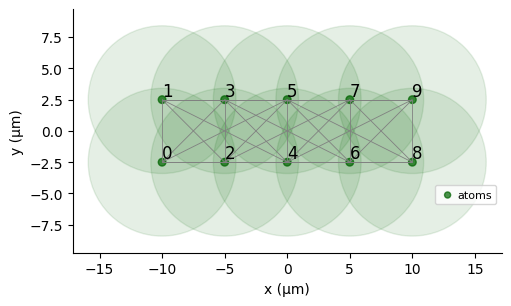

/usr/local/lib/python3.10/dist-packages/pulser/register/register.py:375: UserWarning: Register serialization to an abstract representation irreversibly converts all qubit ID's to strings.
  names = stringify_qubit_ids(self._ids)


In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[13]:


import numpy as np
import pulser
from pprint import pprint
from pulser import Pulse, Sequence, Register
import matplotlib.pyplot as plt
from pulser.devices import Chadoq2
from pulser_simulation import QutipEmulator
from pulser.devices import MockDevice
import qutip


# In[2]:


rows = 2
cols = 5

# Calculate the grid coordinates
x = np.linspace(0, cols - 1, cols)
y = np.linspace(0, rows - 1, rows)
square = np.array([[i, j] for i in x for j in y], dtype=float)

# Adjust the coordinates
square -= np.mean(square, axis=0)
square *= max(rows, cols)


qubits = dict(enumerate(square))
reg1 = Register(qubits)


# In[5]:


reg1.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(2.0),
    draw_graph=True,
    draw_half_radius=True,)


# In[6]:


seq = Sequence(reg1, Chadoq2)

seq.declare_channel("local1", "raman_local")
seq.declare_channel("local2", 'rydberg_local')
seq.declare_channel("global", 'rydberg_global')

seq.target(0,"local1")
seq.target(1,"local2")


# In[8]:


N = 10

#define local detuning
W = np.random.randint(1,11,N)
detuning = W

#rescale_detuing (set maximum detuing to be 100 minimum to be 0)
def rescale(w):
    xmin = np.min(w)
    xmax = np.max(w)
    rescaled_detun = [(w[i]-xmin)*100/(xmax-xmin) for i in range(len(w))]
    return rescaled_detun

rescaled_detuning = rescale(detuning)


# In[11]:


rescaled_detuning


# In[9]:


#duration of a pulse
duration = 48

#constant rabi pulse for 50ns 2rad/s and 0 detuning
rabi_simple_pulse = Pulse.ConstantPulse(duration, 2, 0, 0)


#a list of constant local detuning pulses
local_simple_pulse = [Pulse.ConstantPulse(duration, 0, rescaled_detuning[i], 0) for i in range(N)]

#Define number of trotterization
iteration = 32

trott = 0
while trott < iteration:
    trott += 1

    #Each trotterization starts with a global rabi drive
    seq.add(rabi_simple_pulse, "global")
    seq.delay(duration,"local1")
    seq.delay(duration,"local2")

    #A series of  local detuing
    for i in range(N//2):
        seq.target(2*i, "local1")
        seq.target(2*i+1, "local2")

        seq.add(local_simple_pulse[2*i], "local1",protocol="no-delay")
        seq.add(local_simple_pulse[2*i+1], "local2",protocol="no-delay")


    if N%2 != 0:
        seq.target(N-1,"local1")
        seq.target(0,"local2")
        seq.add(local_simple_pulse[N-1],"local1",protocol="no-delay")
        seq.add(Pulse.ConstantPulse(duration, 2, 0, 0),"local2")
serialized_sequence = seq.to_abstract_repr()
seq.measure(basis="ground-rydberg")








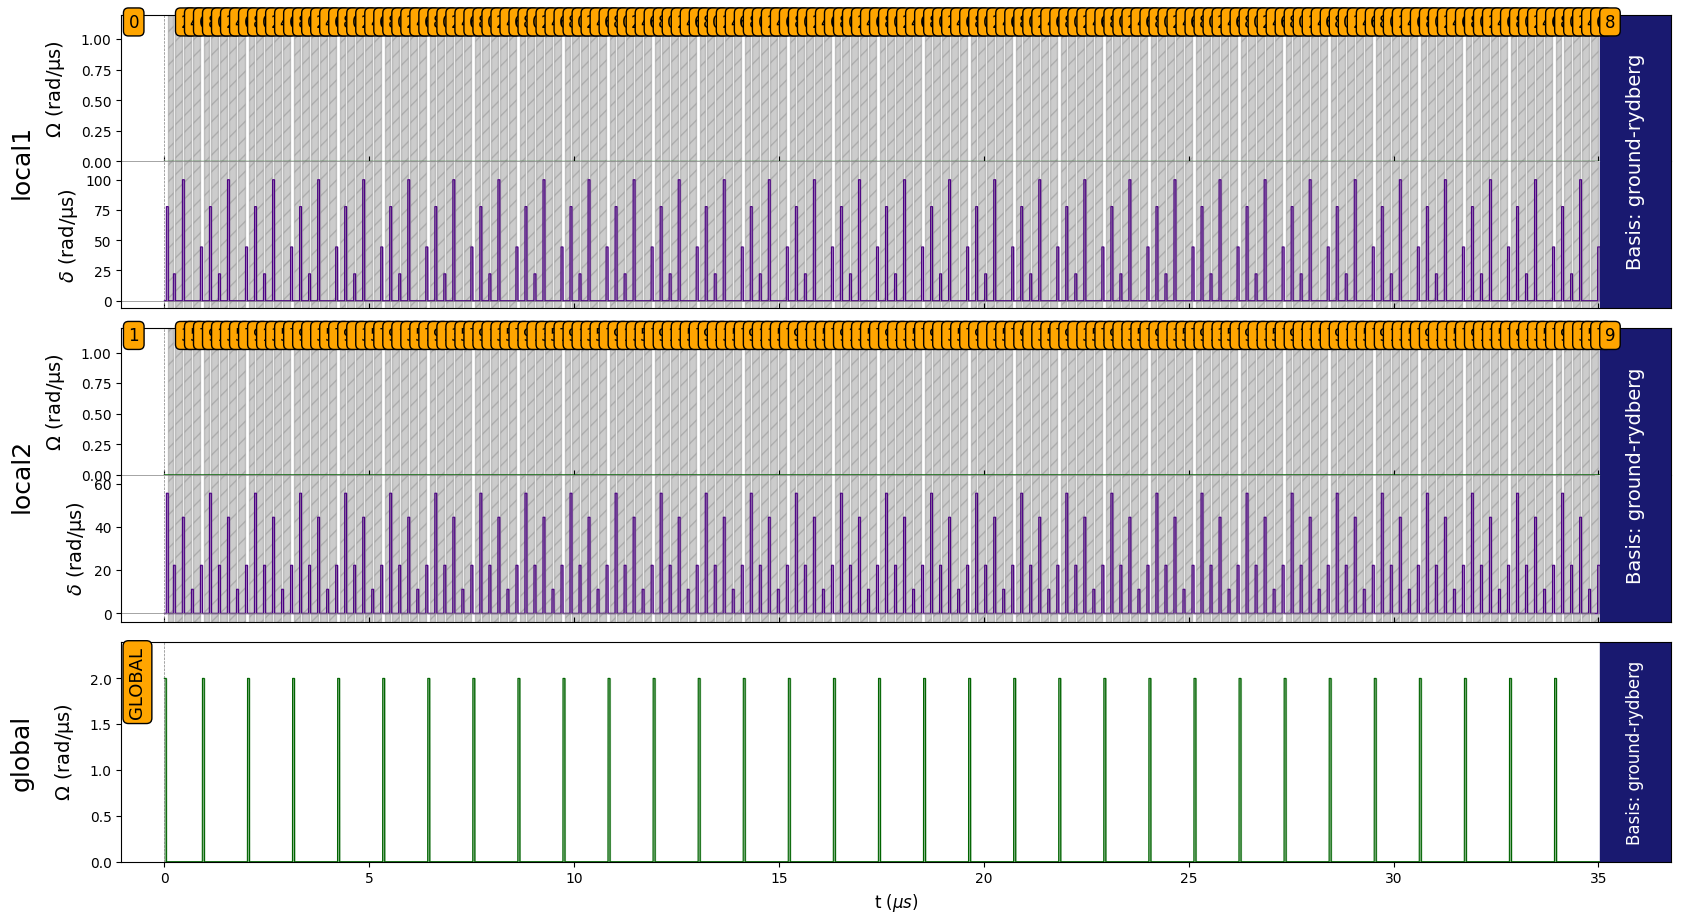

In [ ]:
seq.draw()

In [ ]:
#!pip install pasqal-cloud

In [ ]:
from pasqal_cloud.device import EmulatorType
job1 = {"runs": 100}
job2 = {"runs": 500}
serialized_sequence = seq.to_abstract_repr()
batch = sdk.create_batch(
    serialized_sequence, [job1], emulator=EmulatorType.EMU_FREE
)

/usr/local/lib/python3.10/dist-packages/pulser/register/register.py:375: UserWarning: Register serialization to an abstract representation irreversibly converts all qubit ID's to strings.
  names = stringify_qubit_ids(self._ids)


In [ ]:
for job in batch.ordered_jobs:
    print(f"job-id: {job.id}, status: {job.status}, result: {job.result}")

job-id: 73fb140e-3548-4b50-802f-b04acc7520bf, status: PENDING, result: None
